<a href="https://colab.research.google.com/github/LenaGeller/retail_demand_analysis/blob/main/data_prep_Perischable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests
import io

# Build the direct download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

# Dictionary of file IDs for clarity
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

# Load each CSV using the helper functions
df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
# df_train          = load_csv_from_url(make_drive_url(file_ids["train"])) we dont read it as the file is too big and wont work this way
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))


In [2]:
import gdown

# Use our existing function to build the download URL
train_url = make_drive_url(file_ids["train"])

# Download the file using gdown
gdown.download(train_url, "train.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=47541b0e-86ab-42b2-af1a-a8d9d35cd7cf
To: /content/train.csv
100%|██████████| 5.00G/5.00G [00:54<00:00, 92.4MB/s]


'train.csv'

In [3]:
store_ids = df_stores[df_stores['state'] == 'Pichincha']['store_nbr'].unique()
min_date = '2015-01-01'
max_date = '2017-04-01'
import pandas as pd

chunk_size = 10**6  # 1 million rows at a time
filtered_chunks = []

for chunk in pd.read_csv("train.csv", chunksize=chunk_size):
    chunk_filtered = chunk[(chunk['date'] >= min_date) & (chunk['date']<max_date)]
    filtered_chunks.append(chunk_filtered)
    del chunk  # Free up memory
df_train = pd.concat(filtered_chunks, ignore_index=True)
del filtered_chunks
# Loads first 5 rows
df_train.head(5)

/tmp/ipython-input-3186655493.py:9: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("train.csv", chunksize=chunk_size):


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,38594264,2015-01-01,25,103665,12.0,False
1,38594265,2015-01-01,25,105575,23.0,False
2,38594266,2015-01-01,25,108634,1.0,False
3,38594267,2015-01-01,25,108698,6.0,False
4,38594268,2015-01-01,25,108786,6.0,False


In [4]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [5]:
# 1. Nur verderbliche Items
perishable_items = df_items[df_items["perishable"] == 1]

# 2. Familie mit höchstem Verkaufsvolumen
family_sales = df_train.merge(perishable_items, on="item_nbr") \
                       .groupby("family")["unit_sales"].sum()
best_family = family_sales.idxmax()
print("Beste verderbliche Familie:", best_family)

# 3. Items dieser Familie
best_items = perishable_items[perishable_items["family"] == best_family]["item_nbr"]

# 4. df_train auf diese Items beschränken
df_train_best = df_train[df_train["item_nbr"].isin(best_items)]

# Verkäufe pro Item nur innerhalb PRODUCE
item_sales = (
    df_train_best.groupby("item_nbr")["unit_sales"]
    .sum()
    .sort_values(ascending=False)
)

# Top-3 Items auswählen
top3_items = item_sales.head(3).index
print("Top 3 PRODUCE Items:", top3_items.tolist())

# Trainingsdaten auf diese Items beschränken
df_produce_top3 = df_train_best[df_train_best["item_nbr"].isin(top3_items)]
df_produce_top3.info()



Beste verderbliche Familie: PRODUCE
Top 3 PRODUCE Items: [1503844, 1473474, 1695835]
<class 'pandas.core.frame.DataFrame'>
Index: 73208 entries, 9305354 to 72412945
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           73208 non-null  int64  
 1   date         73208 non-null  object 
 2   store_nbr    73208 non-null  int64  
 3   item_nbr     73208 non-null  int64  
 4   unit_sales   73208 non-null  float64
 5   onpromotion  73208 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 3.9+ MB


In [6]:
# Prüfen ob alle drei Items im gefilterten Datensatz vorkommen
print(df_produce_top3["item_nbr"].unique())

# Verkäufe pro Item summieren
sales_per_item = df_produce_top3.groupby("item_nbr")["unit_sales"].sum()
print(sales_per_item)

# Extra check nur für das dritte Item
item_id = 1463992
print(df_produce_top3[df_produce_top3["item_nbr"] == item_id].head())
print("Summe Verkäufe:", df_produce_top3[df_produce_top3["item_nbr"] == item_id]["unit_sales"].sum())


[1473474 1503844 1695835]
item_nbr
1473474    3215550.628
1503844    4066013.636
1695835    1670230.467
Name: unit_sales, dtype: float64
Empty DataFrame
Columns: [id, date, store_nbr, item_nbr, unit_sales, onpromotion]
Index: []
Summe Verkäufe: 0.0


# Data Quality Checks

In [7]:
# Checking missing values
df_produce_top3.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0


In [8]:
df_produce_top3.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
9305354,47899618,2015-06-01,1,1473474,107.636,False
9305407,47899671,2015-06-01,1,1503844,157.531,False
9305487,47899751,2015-06-01,1,1695835,19.328,False
9307315,47901579,2015-06-01,2,1473474,108.464,False
9307362,47901626,2015-06-01,2,1503844,198.755,False


In [9]:
# Checking for negative sales (returns)
negative_sales = df_produce_top3[df_produce_top3['unit_sales'] < 0]

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion


In [10]:
df_produce_top3['unit_sales'] = df_produce_top3['unit_sales'].apply(lambda x: max(x, 0))
df_produce_top3[df_produce_top3['unit_sales'] < 0]


/tmp/ipython-input-3891312084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_produce_top3['unit_sales'] = df_produce_top3['unit_sales'].apply(lambda x: max(x, 0))


,id,date,store_nbr,item_nbr,unit_sales,onpromotion


## Outliers

In [11]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score for unit_sales (avoiding division by zero for standard deviation), and store it in a new column called z_score
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

# Apply the Z-score calculation to each store-item group, then flatten the index
df_produce_top3_grouped = df_produce_top3.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_produce_top3_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_produce_top3_grouped[df_produce_top3_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 27


/tmp/ipython-input-4088486179.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_produce_top3_grouped = df_produce_top3.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
9747,101479191,2016-12-30,5,1695835,49.930,False,5.484429
28855,106762381,2017-02-19,23,1695835,75.895,False,5.071438
31102,66308817,2015-12-30,25,1473474,296.700,True,5.220960
31140,69804794,2016-02-06,25,1473474,307.596,False,5.472478
31401,101517627,2016-12-30,25,1473474,291.888,False,5.109882


In [12]:
outliers_with_holidays = outliers.merge(
    df_holiday_events[['date', 'type', 'description']],
    on='date',
    how='left'
)

# Check: welche Outlier fallen auf Feiertage? + Produkt + Store
outliers_with_holidays[['date', 'store_nbr', 'item_nbr',
                        'unit_sales', 'onpromotion', 'type', 'description']].head(20)

,date,store_nbr,item_nbr,unit_sales,onpromotion,type,description
0,2016-12-30,5,1695835,49.930,False,NaN,NaN
1,2017-02-19,23,1695835,75.895,False,NaN,NaN
2,2015-12-30,25,1473474,296.700,True,NaN,NaN
3,2016-02-06,25,1473474,307.596,False,NaN,NaN
4,2016-12-30,25,1473474,291.888,False,NaN,NaN
5,2017-02-25,25,1473474,288.135,False,NaN,NaN
6,2017-02-25,25,1503844,349.785,False,NaN,NaN
7,2016-12-26,25,1695835,333.496,False,Additional,Navidad+1
8,2016-12-30,25,1695835,447.008,False,NaN,NaN
9,2017-02-24,25,1695835,378.474,False,NaN,NaN


In [13]:
unexplained_outliers = outliers_with_holidays[
    (outliers_with_holidays['onpromotion'] == False) &
    (outliers_with_holidays['type'].isna())
]

# mal anschauen
unexplained_outliers[['date', 'store_nbr', 'item_nbr', 'unit_sales']].head(20)


,date,store_nbr,item_nbr,unit_sales
0,2016-12-30,5,1695835,49.930
1,2017-02-19,23,1695835,75.895
3,2016-02-06,25,1473474,307.596
4,2016-12-30,25,1473474,291.888
5,2017-02-25,25,1473474,288.135
6,2017-02-25,25,1503844,349.785
8,2016-12-30,25,1695835,447.008
9,2017-02-24,25,1695835,378.474
10,2017-02-25,25,1695835,309.697
12,2017-01-22,26,1503844,552.448


In [14]:
len(unexplained_outliers)

16

In [15]:
unexplained_outliers['item_nbr'].value_counts().head(10)


,count
item_nbr,
1695835,10
1473474,3
1503844,3


In [16]:

cap_values = df_produce_top3.groupby('item_nbr')['unit_sales'].quantile(0.99)

# 2. Funktion zum Capping definieren
def cap_outliers(row):
    if row.name in unexplained_outliers.index:  # nur auf unexplained anwenden
        cap = cap_values[row['item_nbr']]
        return min(row['unit_sales'], cap)
    else:
        return row['unit_sales']

# 3. Neue Spalte mit gekappten Werten
df_produce_top3['unit_sales_capped'] = df_produce_top3.apply(cap_outliers, axis=1)


capped_count = (df_produce_top3['unit_sales'] != df_produce_top3['unit_sales_capped']).sum()
print(f"Anzahl gekappter Outlier: {capped_count}")

# 5. Optional: ein paar Beispiele zeigen
df_produce_top3.loc[df_produce_top3['unit_sales'] != df_produce_top3['unit_sales_capped'],
             ['date', 'store_nbr', 'item_nbr', 'unit_sales', 'unit_sales_capped']].head(10)

Anzahl gekappter Outlier: 0


/tmp/ipython-input-2326418365.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_produce_top3['unit_sales_capped'] = df_produce_top3.apply(cap_outliers, axis=1)


,date,store_nbr,item_nbr,unit_sales,unit_sales_capped


In [17]:
df_produce_top3["unit_sales_capped"] = df_produce_top3["unit_sales"]

/tmp/ipython-input-860595941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_produce_top3["unit_sales_capped"] = df_produce_top3["unit_sales"]


# Fill Calender

In [18]:
df_produce_top3 = df_produce_top3.copy()
df_produce_top3["date"] = pd.to_datetime(df_produce_top3["date"])


In [19]:
def fill_calendar(group):
    #
    # group contains all rows for ONE (store_nbr, item_nbr) pair
    #
    g = group.set_index("date").sort_index()          # use date/calendar as the index
    g = g.asfreq("D", fill_value=0)                   # make it daily; add 0 where missing

    # put the identifiers back (asfreq drops them)
    g["store_nbr"] = group["store_nbr"].iloc[0]
    g["item_nbr"]  = group["item_nbr"].iloc[0]

    return g.reset_index()                            # date back to a normal column


In [20]:
df_produce_top3 = (
    df_produce_top3
    .groupby(["store_nbr", "item_nbr"], group_keys=False)  # keeps memory low
    .apply(fill_calendar)
)
df_produce_top3.head()

/tmp/ipython-input-4233291623.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_calendar)


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_capped
0,2015-06-01,47899618,1,1473474,107.636,False,107.636
1,2015-06-02,47980434,1,1473474,93.536,False,93.536
2,2015-06-03,48060600,1,1473474,224.225,True,224.225
3,2015-06-04,48139479,1,1473474,111.914,False,111.914
4,2015-06-05,48216664,1,1473474,134.079,False,134.079


# Date Transformation

In [21]:
# Make sure 'date' is a real datetime
df_produce_top3['date'] = pd.to_datetime(df_produce_top3['date'])

# Split the timestamp into model-friendly parts
df_produce_top3['year'] = df_produce_top3['date'].dt.year
df_produce_top3['month'] = df_produce_top3['date'].dt.month
df_produce_top3['day'] = df_produce_top3['date'].dt.day
df_produce_top3['day_of_week'] = df_produce_top3['date'].dt.dayofweek # Monday=0 … Sunday=6

# Lets check the result
df_produce_top3.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_capped,year,month,day,day_of_week
0,2015-06-01,47899618,1,1473474,107.636,False,107.636,2015,6,1,0
1,2015-06-02,47980434,1,1473474,93.536,False,93.536,2015,6,2,1
2,2015-06-03,48060600,1,1473474,224.225,True,224.225,2015,6,3,2
3,2015-06-04,48139479,1,1473474,111.914,False,111.914,2015,6,4,3
4,2015-06-05,48216664,1,1473474,134.079,False,134.079,2015,6,5,4


# Moving Means and Medians

In [22]:
# Sortieren nach Item, Store, Datum
df_produce_top3 = df_produce_top3.sort_values(
    ["item_nbr", "store_nbr", "date"]
).reset_index(drop=True)

# Rolling Features: 7, 14, 28 Tage
for window in [7, 14, 28]:
    df_produce_top3[f"unit_sales_{window}d_avg"] = (
        df_produce_top3
        .groupby(["item_nbr", "store_nbr"])["unit_sales"]
        .transform(lambda s: s.rolling(window=window, min_periods=1).mean())
    )
    df_produce_top3[f"unit_sales_{window}d_std"] = (
        df_produce_top3
        .groupby(["item_nbr", "store_nbr"])["unit_sales"]
        .transform(lambda s: s.rolling(window=window, min_periods=1).std())
    )

df_produce_top3.head(10)


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_capped,year,month,day,day_of_week,unit_sales_7d_avg,unit_sales_7d_std,unit_sales_14d_avg,unit_sales_14d_std,unit_sales_28d_avg,unit_sales_28d_std
0,2015-06-01,47899618,1,1473474,107.636,False,107.636,2015,6,1,0,107.636000,NaN,107.636000,NaN,107.636000,NaN
1,2015-06-02,47980434,1,1473474,93.536,False,93.536,2015,6,2,1,100.586000,9.970206,100.586000,9.970206,100.586000,9.970206
2,2015-06-03,48060600,1,1473474,224.225,True,224.225,2015,6,3,2,141.799000,71.730305,141.799000,71.730305,141.799000,71.730305
3,2015-06-04,48139479,1,1473474,111.914,False,111.914,2015,6,4,3,134.327750,60.443660,134.327750,60.443660,134.327750,60.443660
4,2015-06-05,48216664,1,1473474,134.079,False,134.079,2015,6,5,4,134.278000,52.345863,134.278000,52.345863,134.278000,52.345863
5,2015-06-06,48294399,1,1473474,133.312,False,133.312,2015,6,6,5,134.117000,46.821224,134.117000,46.821224,134.117000,46.821224
6,2015-06-07,48377845,1,1473474,51.073,False,51.073,2015,6,7,6,122.253571,53.028694,122.253571,53.028694,122.253571,53.028694
7,2015-06-08,48462537,1,1473474,143.291,False,143.291,2015,6,8,0,127.347143,53.102956,124.883250,49.655249,124.883250,49.655249
8,2015-06-09,48540745,1,1473474,106.609,False,106.609,2015,6,9,1,129.214714,51.932658,122.852778,46.845957,122.852778,46.845957
9,2015-06-10,48617780,1,1473474,176.000,True,176.000,2015,6,10,2,122.325429,38.754954,128.167500,47.256409,128.167500,47.256409


In [23]:
# Lets see how the new column unit_sales_7d_avg looks like. For that, we'll need to select a store and item.
# Get store and item from the first row
store_id = df_produce_top3.iloc[0]['store_nbr']
item_id = df_produce_top3.iloc[0]['item_nbr']

# Filter the DataFrame for this store-item pair
sample = df_produce_top3[(df_produce_top3['store_nbr'] == store_id) & (df_produce_top3['item_nbr'] == item_id)]
sample.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_capped,year,month,day,day_of_week,unit_sales_7d_avg,unit_sales_7d_std,unit_sales_14d_avg,unit_sales_14d_std,unit_sales_28d_avg,unit_sales_28d_std
0,2015-06-01,47899618,1,1473474,107.636,False,107.636,2015,6,1,0,107.63600,NaN,107.63600,NaN,107.63600,NaN
1,2015-06-02,47980434,1,1473474,93.536,False,93.536,2015,6,2,1,100.58600,9.970206,100.58600,9.970206,100.58600,9.970206
2,2015-06-03,48060600,1,1473474,224.225,True,224.225,2015,6,3,2,141.79900,71.730305,141.79900,71.730305,141.79900,71.730305
3,2015-06-04,48139479,1,1473474,111.914,False,111.914,2015,6,4,3,134.32775,60.443660,134.32775,60.443660,134.32775,60.443660
4,2015-06-05,48216664,1,1473474,134.079,False,134.079,2015,6,5,4,134.27800,52.345863,134.27800,52.345863,134.27800,52.345863


In [24]:
# nutzlose Spalte droppen
df_produce_top3 = df_produce_top3.drop(columns=["unit_sales_capped"], errors="ignore")

df_produce_top3.head()


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,unit_sales_7d_std,unit_sales_14d_avg,unit_sales_14d_std,unit_sales_28d_avg,unit_sales_28d_std
0,2015-06-01,47899618,1,1473474,107.636,False,2015,6,1,0,107.63600,NaN,107.63600,NaN,107.63600,NaN
1,2015-06-02,47980434,1,1473474,93.536,False,2015,6,2,1,100.58600,9.970206,100.58600,9.970206,100.58600,9.970206
2,2015-06-03,48060600,1,1473474,224.225,True,2015,6,3,2,141.79900,71.730305,141.79900,71.730305,141.79900,71.730305
3,2015-06-04,48139479,1,1473474,111.914,False,2015,6,4,3,134.32775,60.443660,134.32775,60.443660,134.32775,60.443660
4,2015-06-05,48216664,1,1473474,134.079,False,2015,6,5,4,134.27800,52.345863,134.27800,52.345863,134.27800,52.345863


In [25]:
# 1.  Mount Drive (one-time click to authorize)
from google.colab import drive
drive.mount('/content/drive')

# 2.  Pick a folder inside Drive (create it if it doesn’t exist)
save_path = "/content/drive/MyDrive/Time Series/df_produce_top3.pkl" # example of path

# 3.  SAVE the cleaned DataFrame
df_produce_top3.to_pickle(save_path)
print(f"Saved to: {save_path}")

Mounted at /content/drive
Saved to: /content/drive/MyDrive/Time Series/df_produce_top3.pkl


In [26]:
from google.colab import drive
drive.mount('/content/drive')                # re-mount
load_path = "/content/drive/MyDrive/Time Series/df_produce_top3.pkl" #example of path, use the same as above
df_train = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame reloaded, ready to go!


In [27]:


df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,unit_sales_7d_std,unit_sales_14d_avg,unit_sales_14d_std,unit_sales_28d_avg,unit_sales_28d_std
0,2015-06-01,47899618,1,1473474,107.636,False,2015,6,1,0,107.63600,NaN,107.63600,NaN,107.63600,NaN
1,2015-06-02,47980434,1,1473474,93.536,False,2015,6,2,1,100.58600,9.970206,100.58600,9.970206,100.58600,9.970206
2,2015-06-03,48060600,1,1473474,224.225,True,2015,6,3,2,141.79900,71.730305,141.79900,71.730305,141.79900,71.730305
3,2015-06-04,48139479,1,1473474,111.914,False,2015,6,4,3,134.32775,60.443660,134.32775,60.443660,134.32775,60.443660
4,2015-06-05,48216664,1,1473474,134.079,False,2015,6,5,4,134.27800,52.345863,134.27800,52.345863,134.27800,52.345863


# Vizualizatoins

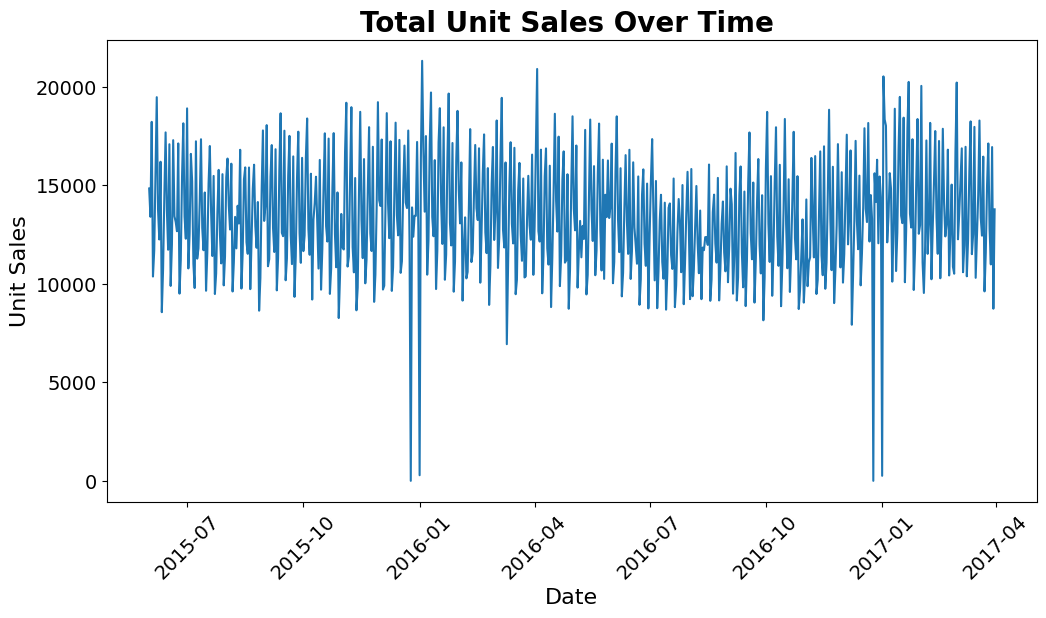

In [28]:
import matplotlib.pyplot as plt

# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time ', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

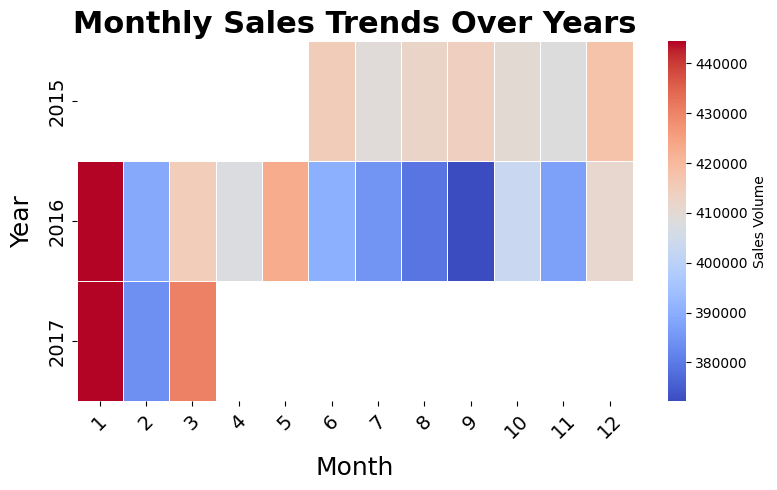

In [29]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Plotting heatmap of sales by year and month
import seaborn as sns

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility

sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

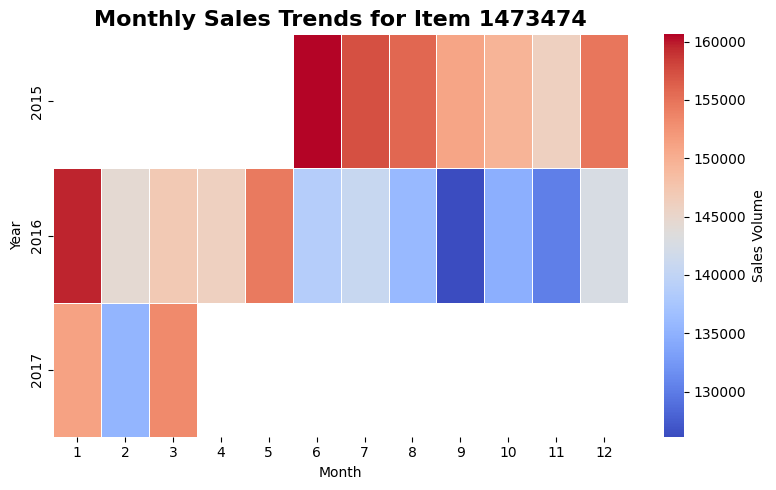

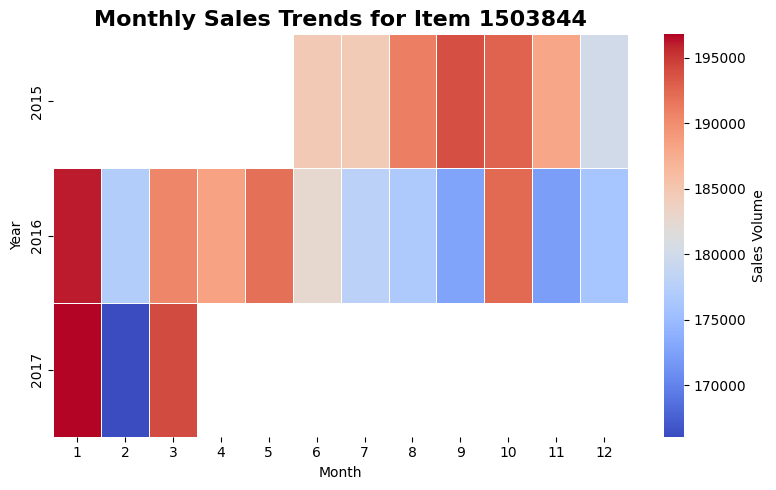

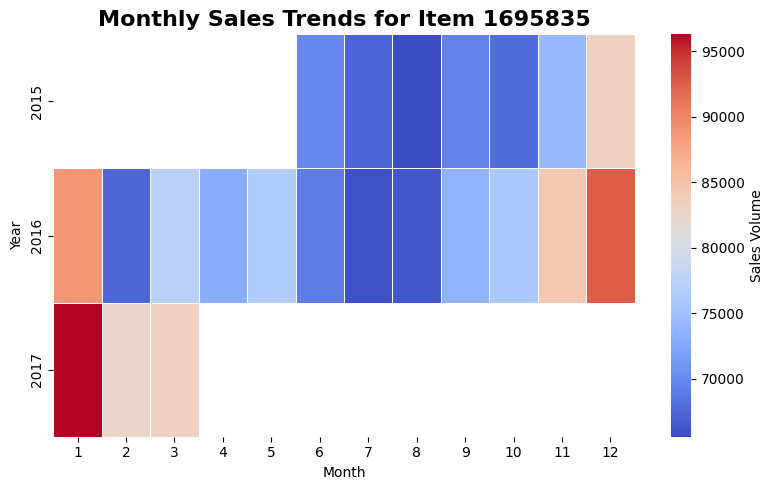

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Für jedes Item eine eigene Heatmap
for item in df_train['item_nbr'].unique():
    sales_by_month_item = (
        df_train[df_train['item_nbr'] == item]
        .groupby(['year', 'month'])['unit_sales']
        .sum()
        .unstack()
    )

    plt.figure(figsize=(8,5))
    sns.heatmap(
        sales_by_month_item,
        cmap="coolwarm",
        linewidths=0.5,
        linecolor="white",
        cbar_kws={'label': 'Sales Volume'}
    )
    plt.title(f"Monthly Sales Trends for Item {item}", fontsize=16, fontweight="bold")
    plt.xlabel("Month")
    plt.ylabel("Year")
    plt.tight_layout()
    plt.show()


# Holidays Trends

In [31]:
# Convert date column to datetime
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])
print(
    "Holiday file covers:",
    df_holiday_events['date'].dt.date.min(), "→",
    df_holiday_events['date'].dt.date.max()
)

Holiday file covers: 2012-03-02 → 2017-12-26


In [33]:
df_train_holiday = pd.merge(
    df_train,                     # daily sales
    df_holiday_events[['date', 'type']],  # keep only what we need
    on='date',
    how='left'                    # non-holiday days get NaN in 'type'
)
df_train_holiday.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,unit_sales_7d_std,unit_sales_14d_avg,unit_sales_14d_std,unit_sales_28d_avg,unit_sales_28d_std,type
0,2015-06-01,47899618,1,1473474,107.636,False,2015,6,1,0,107.63600,NaN,107.63600,NaN,107.63600,NaN,NaN
1,2015-06-02,47980434,1,1473474,93.536,False,2015,6,2,1,100.58600,9.970206,100.58600,9.970206,100.58600,9.970206,NaN
2,2015-06-03,48060600,1,1473474,224.225,True,2015,6,3,2,141.79900,71.730305,141.79900,71.730305,141.79900,71.730305,NaN
3,2015-06-04,48139479,1,1473474,111.914,False,2015,6,4,3,134.32775,60.443660,134.32775,60.443660,134.32775,60.443660,NaN
4,2015-06-05,48216664,1,1473474,134.079,False,2015,6,5,4,134.27800,52.345863,134.27800,52.345863,134.27800,52.345863,NaN


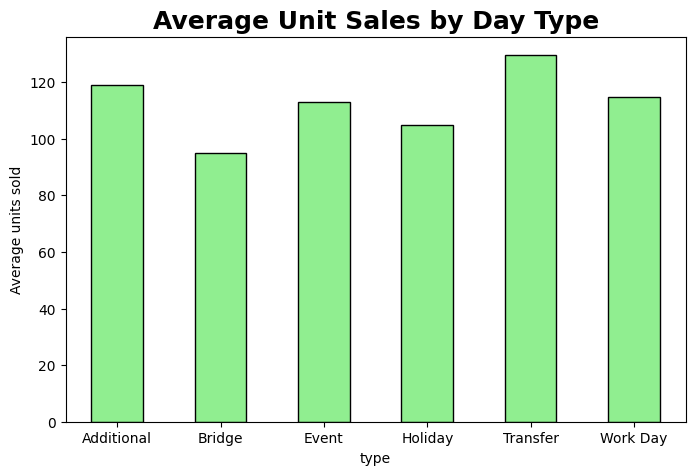

In [35]:
# 4. Compare average sales for each holiday type
# 1–2  average units sold for each day-type
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# 3  bar chart
holiday_sales.plot(kind='bar', figsize=(8,5), color='lightgreen', edgecolor='black')
plt.title('Average Unit Sales by Day Type', fontsize=18, weight='bold')
plt.ylabel('Average units sold')
plt.xticks(rotation=0)
plt.show()

# Oil-prices

In [38]:
df_oil['date'] = pd.to_datetime(df_oil['date'])

df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil = (df_oil
          .set_index('date')
          .asfreq('D')              # lückenloser Tageskalender
          .ffill()                  # Wochenenden/Feiertage vorwärts füllen
          .rename_axis('date')
          .reset_index())
df_oil.head(10)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12
5,2013-01-06,93.12
6,2013-01-07,93.20
7,2013-01-08,93.21
8,2013-01-09,93.08
9,2013-01-10,93.81


In [40]:
daily_sales = (df_train
               .groupby('date')['unit_sales']
               .sum()
               .reset_index())


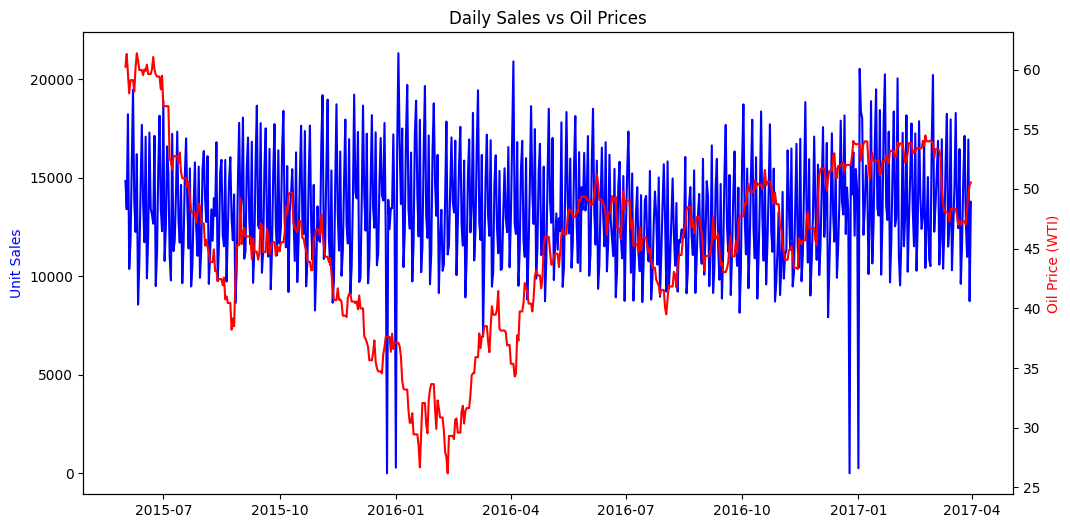

In [42]:
sales_oil = daily_sales.merge(df_oil[['date','dcoilwtico']], on='date', how='left')
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(sales_oil['date'], sales_oil['unit_sales'], color='blue', label='Daily Sales')
ax1.set_ylabel('Unit Sales', color='blue')

ax2 = ax1.twinx()
ax2.plot(sales_oil['date'], sales_oil['dcoilwtico'], color='red', label='Oil Price')
ax2.set_ylabel('Oil Price (WTI)', color='red')

plt.title("Daily Sales vs Oil Prices")
plt.show()



In [43]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


# Autokorrellation

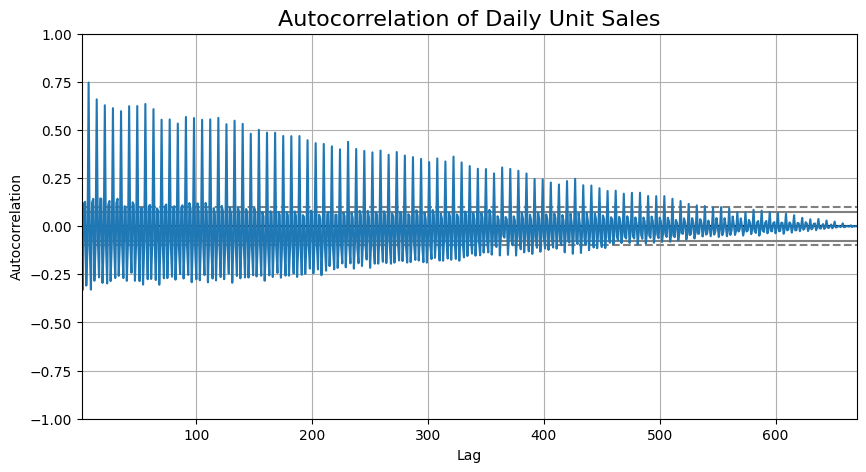

In [44]:
from pandas.plotting import autocorrelation_plot

# Aggregate total sales per day
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plot autocorrelation
plt.figure(figsize=(10, 5))
autocorrelation_plot(sales_by_date)
plt.title('Autocorrelation of Daily Unit Sales', fontsize=16)
plt.show()


# Test for Stationarity

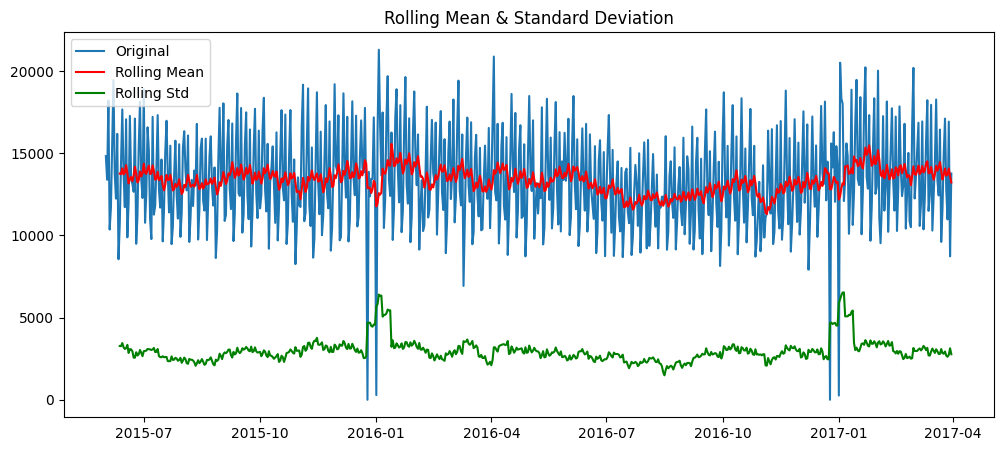

In [45]:
rolling_mean = sales_by_date.rolling(window=12).mean()
rolling_std = sales_by_date.rolling(window=12).std()

plt.figure(figsize=(12,5))
plt.plot(sales_by_date, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

In [46]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 23.0 MB/s eta 0:00:00


In [47]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_by_date)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.6630194353843515
p-value: 0.0806590224059004


# Decomposition




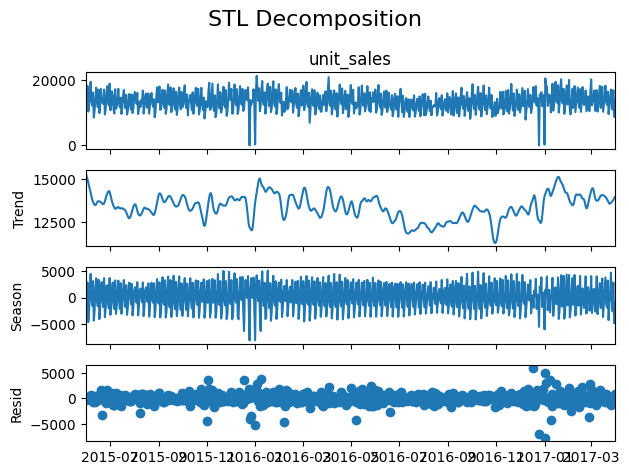

In [48]:
from statsmodels.tsa.seasonal import STL

# STL decomposition
stl = STL(sales_by_date, period=7)  # again, adjust period based on your seasonality
res = stl.fit()

# Plot STL decomposition
res.plot()
plt.suptitle("STL Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

In [49]:
# Calculate strength of trend and seasonality
# Based on Hyndman’s definition: Strength = 1 - (variance of remainder / variance of (component + remainder))

import numpy as np

trend_strength = 1 - (np.var(res.resid) / np.var(res.trend + res.resid))
seasonal_strength = 1 - (np.var(res.resid) / np.var(res.seasonal + res.resid))

print(f"Strength of Trend: {trend_strength:.2f}")
print(f"Strength of Seasonality: {seasonal_strength:.2f}")

Strength of Trend: 0.37
Strength of Seasonality: 0.86


# Saisonalität prüfen

In [50]:
from statsmodels.tsa.stattools import adfuller
y = sales_by_date.asfreq('D')
print("ADF raw:", adfuller(y)[1])                # ~0.027  → d=0
print("ADF seasonal diff(7):", adfuller(y.diff(7).dropna())[1])  # <0.05 → D=1


ADF raw: 0.0806590224059004
ADF seasonal diff(7): 4.257996124700649e-12


# Zusammenführen

In [51]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,unit_sales_7d_std,unit_sales_14d_avg,unit_sales_14d_std,unit_sales_28d_avg,unit_sales_28d_std
0,2015-06-01,47899618,1,1473474,107.636,False,2015,6,1,0,107.63600,NaN,107.63600,NaN,107.63600,NaN
1,2015-06-02,47980434,1,1473474,93.536,False,2015,6,2,1,100.58600,9.970206,100.58600,9.970206,100.58600,9.970206
2,2015-06-03,48060600,1,1473474,224.225,True,2015,6,3,2,141.79900,71.730305,141.79900,71.730305,141.79900,71.730305
3,2015-06-04,48139479,1,1473474,111.914,False,2015,6,4,3,134.32775,60.443660,134.32775,60.443660,134.32775,60.443660
4,2015-06-05,48216664,1,1473474,134.079,False,2015,6,5,4,134.27800,52.345863,134.27800,52.345863,134.27800,52.345863


In [52]:
df_holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [53]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [54]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [55]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [56]:
import pandas as pd

# Datumsfelder
df_train['date']          = pd.to_datetime(df_train['date'])
df_transactions['date']   = pd.to_datetime(df_transactions['date'])
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])

# onpromotion NaN -> False (für exogene Features später wichtig)
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

print("train:", df_train.shape)
print(df_train.head(3))


train: (77841, 16)
        date        id  store_nbr  item_nbr  unit_sales  onpromotion  year  \
0 2015-06-01  47899618          1   1473474     107.636        False  2015   
1 2015-06-02  47980434          1   1473474      93.536        False  2015   
2 2015-06-03  48060600          1   1473474     224.225         True  2015   

   month  day  day_of_week  unit_sales_7d_avg  unit_sales_7d_std  \
0      6    1            0            107.636                NaN   
1      6    2            1            100.586           9.970206   
2      6    3            2            141.799          71.730305   

   unit_sales_14d_avg  unit_sales_14d_std  unit_sales_28d_avg  \
0             107.636                 NaN             107.636   
1             100.586            9.970206             100.586   
2             141.799           71.730305             141.799   

   unit_sales_28d_std  
0                 NaN  
1            9.970206  
2           71.730305  


In [58]:
cols_stores = ['store_nbr','city','state','type','cluster']
train1 = df_train.merge(df_stores[cols_stores], on='store_nbr', how='left')

print("train1 (after stores):", train1.shape)
print(train1[['date','store_nbr','item_nbr','unit_sales','city','state','type','cluster']].head(5))


train1 (after stores): (77841, 20)
        date  store_nbr  item_nbr  unit_sales   city      state type  cluster
0 2015-06-01          1   1473474     107.636  Quito  Pichincha    D       13
1 2015-06-02          1   1473474      93.536  Quito  Pichincha    D       13
2 2015-06-03          1   1473474     224.225  Quito  Pichincha    D       13
3 2015-06-04          1   1473474     111.914  Quito  Pichincha    D       13
4 2015-06-05          1   1473474     134.079  Quito  Pichincha    D       13


In [59]:
tx = df_transactions[['date','store_nbr','transactions']].copy()
train2 = train1.merge(tx, on=['date','store_nbr'], how='left')
train2['transactions'] = train2['transactions'].fillna(0).astype('int32')

print("train2 (after transactions):", train2.shape)
print(train2[['date','store_nbr','transactions']].head(5))


train2 (after transactions): (77841, 21)
        date  store_nbr  transactions
0 2015-06-01          1          1861
1 2015-06-02          1          1852
2 2015-06-03          1          1964
3 2015-06-04          1          1871
4 2015-06-05          1          1921


In [60]:
H = df_holiday_events[['date','type','locale','locale_name','transferred']].copy()

# Basis (eindeutige Paare auf Store-Standortebene)
base = train2[['date','store_nbr','state','city']].drop_duplicates().reset_index(drop=True)

# National: nur Datum
H_nat = H.loc[H['locale'].eq('National'), ['date','type','transferred']]
J_nat = base.merge(H_nat, on='date', how='left')

# Regional: (date, state)
H_reg = (H.loc[H['locale'].eq('Regional'), ['date','type','transferred','locale_name']]
           .rename(columns={'locale_name':'state'}))
J_reg = base.merge(H_reg, on=['date','state'], how='left')

# Local: (date, city)
H_loc = (H.loc[H['locale'].eq('Local'), ['date','type','transferred','locale_name']]
           .rename(columns={'locale_name':'city'}))
J_loc = base.merge(H_loc, on=['date','city'], how='left')

# Zusammenführen und zu Flags aggregieren
HH = pd.concat([J_nat, J_reg, J_loc], ignore_index=True)

HH_flags = (
    HH.assign(
        is_holiday = lambda x: x['type'].isin(['Holiday','Additional','Event']) &
                               (~x['transferred'].fillna(False)),
        is_bridge  = lambda x: x['type'].eq('Bridge'),
        is_transfer= lambda x: x['type'].eq('Transfer'),
        is_work_day= lambda x: x['type'].eq('Work Day'),
    )
    .groupby(['date','store_nbr'], as_index=False)[
        ['is_holiday','is_bridge','is_transfer','is_work_day']
    ].max()
    .fillna(False)
    .astype({'is_holiday':'bool','is_bridge':'bool','is_transfer':'bool','is_work_day':'bool'})
)

print("HH_flags:", HH_flags.shape)
print(HH_flags.head(5))


HH_flags: (32851, 6)
        date  store_nbr  is_holiday  is_bridge  is_transfer  is_work_day
0 2015-06-01          1       False      False        False        False
1 2015-06-01          2       False      False        False        False
2 2015-06-01          3       False      False        False        False
3 2015-06-01          4       False      False        False        False
4 2015-06-01          5       False      False        False        False


/tmp/ipython-input-1160466707.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  (~x['transferred'].fillna(False)),


In [61]:
train3 = train2.merge(HH_flags, on=['date','store_nbr'], how='left')

for c in ['is_holiday','is_bridge','is_transfer','is_work_day']:
    train3[c] = train3[c].fillna(False).astype(bool)

print("train3 (after holiday flags):", train3.shape)
print(train3[['date','store_nbr','is_holiday','is_bridge','is_transfer','is_work_day']].head(8))


train3 (after holiday flags): (77841, 25)
        date  store_nbr  is_holiday  is_bridge  is_transfer  is_work_day
0 2015-06-01          1       False      False        False        False
1 2015-06-02          1       False      False        False        False
2 2015-06-03          1       False      False        False        False
3 2015-06-04          1       False      False        False        False
4 2015-06-05          1       False      False        False        False
5 2015-06-06          1       False      False        False        False
6 2015-06-07          1       False      False        False        False
7 2015-06-08          1       False      False        False        False


In [62]:
cols_items = [c for c in ['item_nbr','family','class'] if c in df_items.columns]
if len(cols_items) >= 2:
    train4 = train3.merge(df_items[cols_items], on='item_nbr', how='left')
else:
    train4 = train3

print("train4 (after items):", train4.shape)
print(train4[['date','store_nbr','item_nbr','family','class']].head(5))


train4 (after items): (77841, 27)
        date  store_nbr  item_nbr   family  class
0 2015-06-01          1   1473474  PRODUCE   2014
1 2015-06-02          1   1473474  PRODUCE   2014
2 2015-06-03          1   1473474  PRODUCE   2014
3 2015-06-04          1   1473474  PRODUCE   2014
4 2015-06-05          1   1473474  PRODUCE   2014


In [63]:
df_train_full = train4.sort_values(['store_nbr','item_nbr','date']).reset_index(drop=True)



print("FINAL:", df_train_full.shape)
print(df_train_full.head(5))


FINAL: (77841, 27)
        date        id  store_nbr  item_nbr  unit_sales  onpromotion  year  \
0 2015-06-01  47899618          1   1473474     107.636        False  2015   
1 2015-06-02  47980434          1   1473474      93.536        False  2015   
2 2015-06-03  48060600          1   1473474     224.225         True  2015   
3 2015-06-04  48139479          1   1473474     111.914        False  2015   
4 2015-06-05  48216664          1   1473474     134.079        False  2015   

   month  day  day_of_week  ...      state  type  cluster  transactions  \
0      6    1            0  ...  Pichincha     D       13          1861   
1      6    2            1  ...  Pichincha     D       13          1852   
2      6    3            2  ...  Pichincha     D       13          1964   
3      6    4            3  ...  Pichincha     D       13          1871   
4      6    5            4  ...  Pichincha     D       13          1921   

   is_holiday  is_bridge is_transfer is_work_day   family  cl

In [64]:
drop_cols = ['unit_sales', 'state', 'family']
df_train_full = df_train_full.drop(columns=drop_cols, errors='ignore')

print("Nach Drop:", list(df_train_full.columns))


Nach Drop: ['date', 'id', 'store_nbr', 'item_nbr', 'onpromotion', 'year', 'month', 'day', 'day_of_week', 'unit_sales_7d_avg', 'unit_sales_7d_std', 'unit_sales_14d_avg', 'unit_sales_14d_std', 'unit_sales_28d_avg', 'unit_sales_28d_std', 'city', 'type', 'cluster', 'transactions', 'is_holiday', 'is_bridge', 'is_transfer', 'is_work_day', 'class']


In [65]:
null_summary = df_train_full.isna().sum()
print(null_summary[null_summary > 0])


unit_sales_7d_std     132
unit_sales_14d_std    132
unit_sales_28d_std    132
dtype: int64


In [66]:
df_train_full.isnull().sum()

,0
date,0
id,0
store_nbr,0
item_nbr,0
onpromotion,0
year,0
month,0
day,0
day_of_week,0
unit_sales_7d_avg,0


In [69]:
df_train_full = df_train_full.dropna()


In [72]:
# als CSV speichern
df_train_full.to_csv("produce2015-2017_prepared.csv", index=False)

print("CSV gespeichert: produce2015-2017_prepared.csv")


CSV gespeichert: produce2015-2017_prepared.csv


In [73]:
# 1.  Mount Drive (one-time click to authorize)
from google.colab import drive
drive.mount('/content/drive')

# 2.  Pick a folder inside Drive (create it if it doesn’t exist)
save_path = "/content/drive/MyDrive/Time Series/produce2015-2017_prepared.pkl" # example of path

# 3.  SAVE the cleaned DataFrame
df_train_full.to_pickle(save_path)
print(f"Saved to: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved to: /content/drive/MyDrive/Time Series/produce2015-2017_prepared.pkl
